In [1]:
import os
import sys
import ast
import pickle

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from BuildingOccupancy import Person, Meeting, WeeklyMeeting, OneTimeMeeting, BuildingOccupancy
from DefaultBuildings import Building_5ZoneAirCooled
from Agents import agent_constructor
from CentralController import ddpg_episode_mc
import RLCritics
import StateUtilities as SU

In [4]:
import visualization_helper as vh

In [76]:
#dirname1 = '../checkpoints/s002/20210322-1350/'
#dirname1 = '../checkpoints/s003/20210322-2147/'
#dirname1 = '../checkpoints/s005/20210323-1438/'
#dirname1 = '../checkpoints/b002/' # baseline chicago
dirname2 = '../checkpoints/b001/'  # baseline fairfax
#dirname2 = '../checkpoints/t003/'

#dirname1 = '../checkpoints/s002/20210319-1736/'
#dirname2 = '../checkpoints/s002/20210318-2238/'

dirname1 = '../checkpoints/s006/20210324-1820/'
#dirname1 = '../checkpoints/s007/'
#dirname2 = '../checkpoints/s004/20210319-1742/'

multioutput = True

In [77]:
dfs1 = vh.convert_sqlite_to_df(dirname1)

Table eees convertet to a pandas dataframe.
Table eeesea convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.


In [78]:
dfs2 = vh.convert_sqlite_to_df(dirname2)

Table eees convertet to a pandas dataframe.
Table eeesea convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.


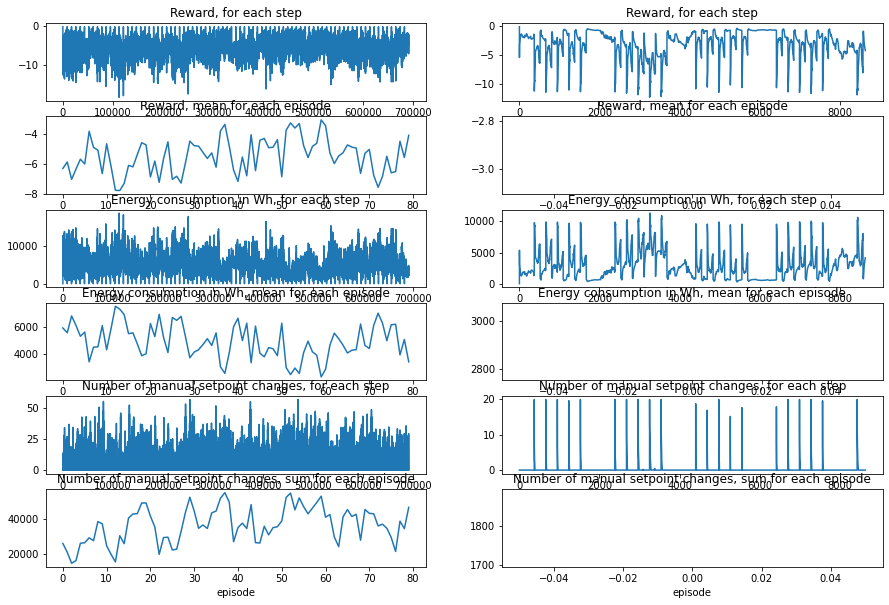

In [79]:
_, axes = plt.subplots(nrows=6, ncols=2, figsize=(15,10), sharex=False)
vh.plot_eees(dfs1, axes[:, 0])
vh.plot_eees(dfs2, axes[:, 1])

No data to plot


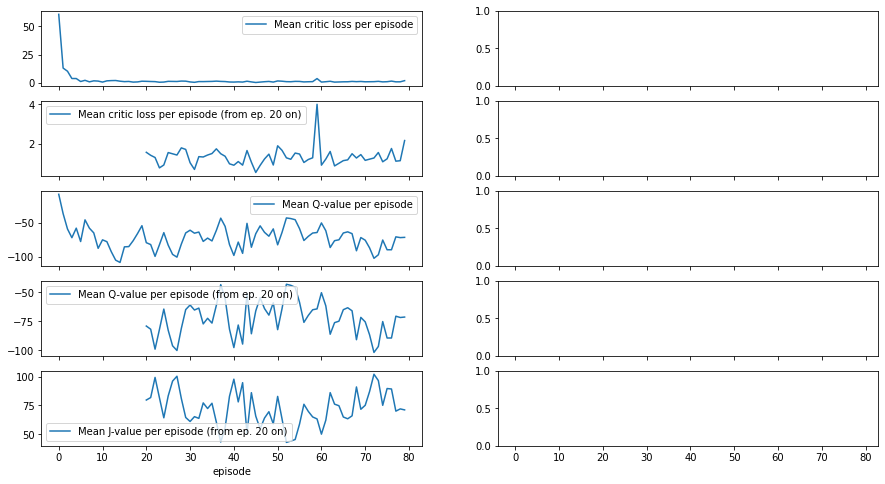

In [80]:
_, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,8), sharex=True)
vh.plot_eeesea(dfs1, axes[:, 0])
vh.plot_eeesea(dfs2, axes[:, 1])

No data to plot


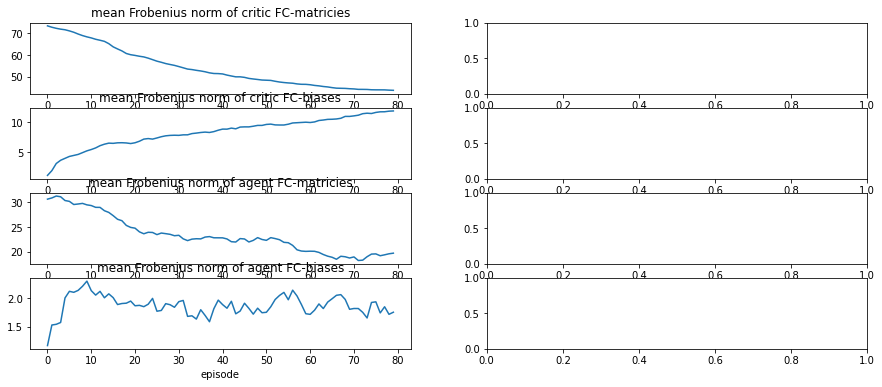

In [81]:
_, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,6))
vh.plot_eeesea_frobnorm(dfs1, axes[:, 0])
vh.plot_eeesea_frobnorm(dfs2, axes[:, 1])

<h3>Details: Temperatur Setpoints</h3>

In [91]:
selected_episode = 20 - 1
selected_room    = 0 # i.e. SPACE1-1
selected_agent   = 0 # ID of the agent
selected_week    = datetime.datetime(2017, 1, 1)
selected_week2   = datetime.datetime(2017, 1, 1)
#selected_week2   = datetime.datetime(2020, 7, 22)

subdfs1 = vh.select_week_and_episode(dfs1, selected_episode, selected_week)
#subdfs1 = vh.select_week_and_episode(dfs1, 0, selected_week)
#subdfs2 = vh.select_week_and_episode(dfs2, selected_episode, selected_week2)
subdfs2 = vh.select_week_and_episode(dfs2, 0, selected_week2)

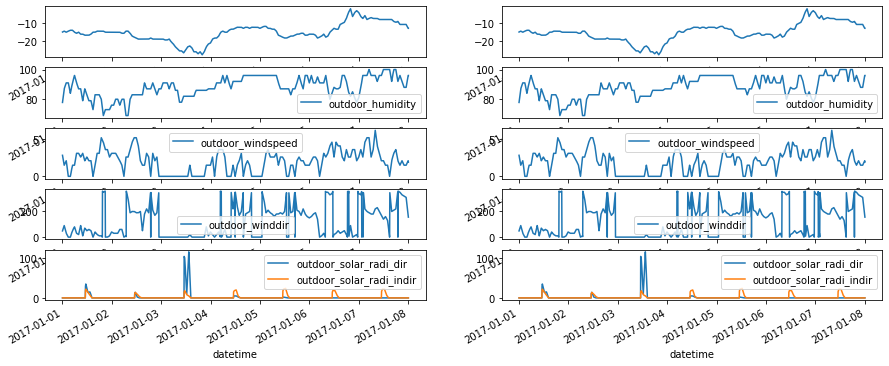

In [92]:
_, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,6))
vh.plot_sees(subdfs1, axes[:, 0])
vh.plot_sees(subdfs2, axes[:, 1])

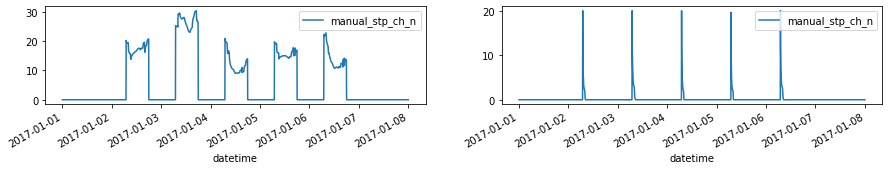

In [93]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,2))
vh.plot_eees_only_mstpc(subdfs1, axes[0])
vh.plot_eees_only_mstpc(subdfs2, axes[1])

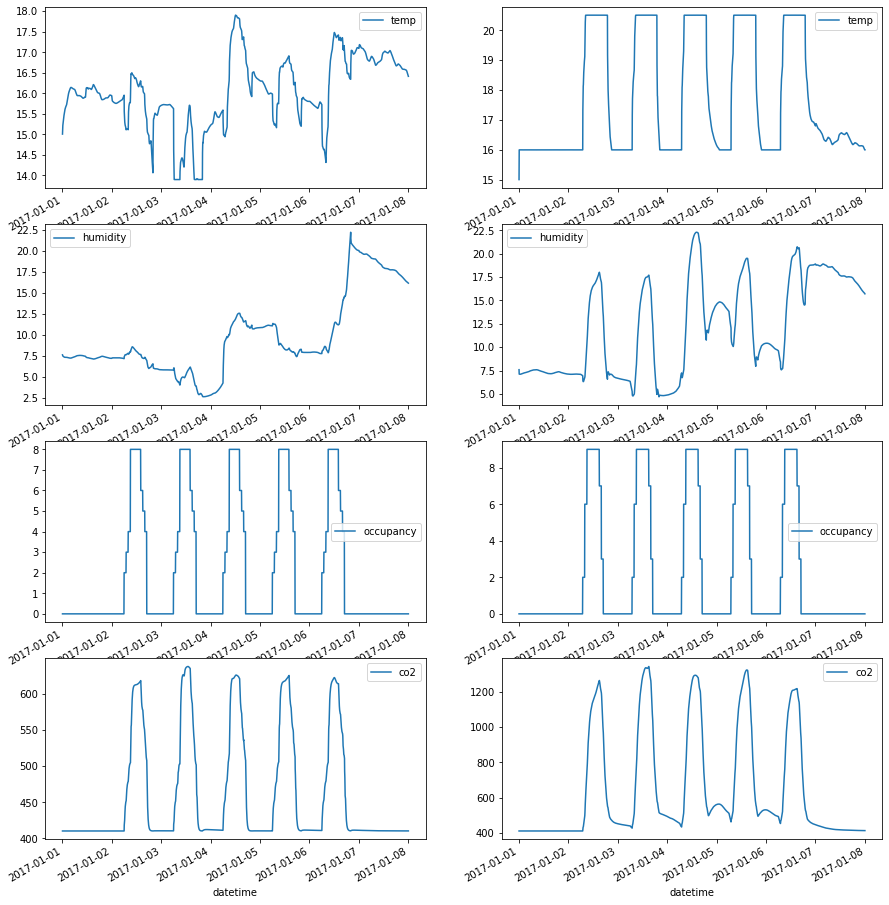

In [94]:
_, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,17))
vh.plot_seeser(subdfs1, selected_room, axes[:, 0])
vh.plot_seeser(subdfs2, selected_room, axes[:, 1])

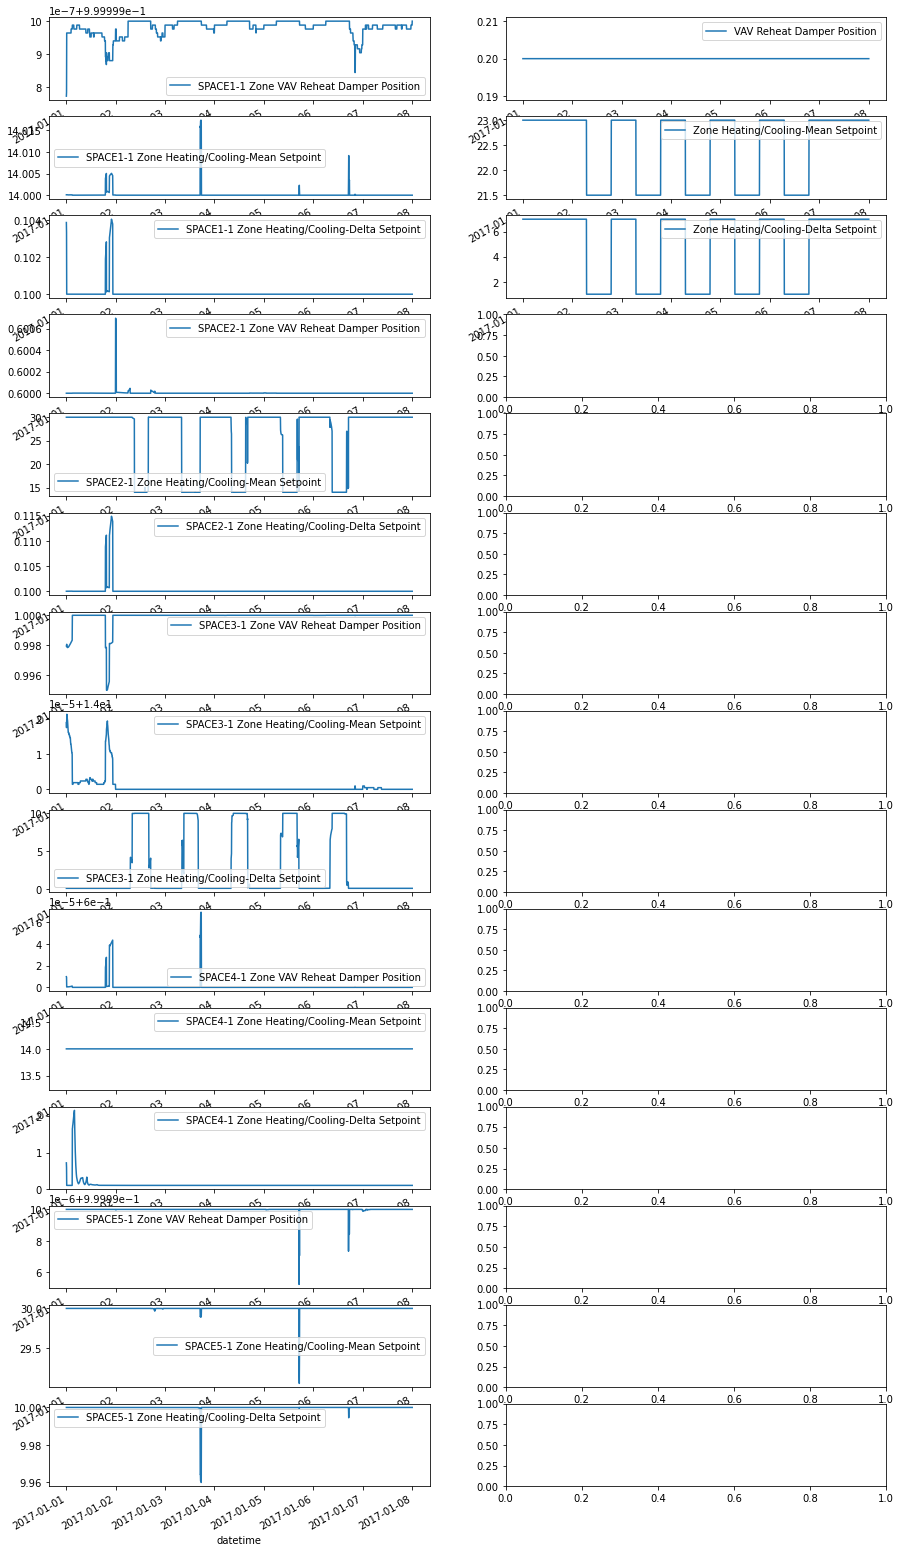

In [95]:
_, axes = plt.subplots(nrows=15, ncols=2, figsize=(15,30))
vh.plot_seesea(subdfs1, selected_agent, axes[:, 0])
vh.plot_seesea(subdfs2, selected_agent, axes[:, 1])

In [ ]:
ag_actions = pd.DataFrame([ ast.literal_eval( action )
                  for action
                  in seesea_sdf.reset_index().loc[:, "agent_actions"] ])

In [ ]:
_, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,8), sharex=True)
ag_actions.loc[:, ['SPACE1-1 Zone VAV Reheat Damper Position']].plot(ax=axes[0])
(ag_actions.loc[:, 'SPACE1-1 Zone Heating/Cooling-Mean Setpoint'] +
 ag_actions.loc[:, 'SPACE1-1 Zone Heating/Cooling-Delta Setpoint']).plot(ax=axes[1], label="Heating Setpoint")
(ag_actions.loc[:, 'SPACE1-1 Zone Heating/Cooling-Mean Setpoint'] -
 ag_actions.loc[:, 'SPACE1-1 Zone Heating/Cooling-Delta Setpoint']).plot(ax=axes[1], label="Cooling Setpoint")
ag_actions.loc[:, 'SPACE1-1 Zone Heating/Cooling-Mean Setpoint'].plot(ax=axes[1], label="Mean Setpoint")
axes[1].legend()
ag_actions.loc[:, 'SPACE1-1 Zone Heating/Cooling-Delta Setpoint'].plot(ax=axes[2], label="Heating/Cooling Delta")
axes[2].legend()